#### Library import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

import re
from tqdm import tqdm

#### GPU setting

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [3]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5321737719463193824
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 278156403023772941
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [5]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [6]:
data = pd.read_csv("data/data.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [7]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [8]:
As = data
Cd = data
Ni = data

In [9]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [10]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(1458, 16)
(1458, 16)
(1458, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [11]:
import smogn

In [12]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme')
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme')

synth_matrix: 100%|##########| 242/242 [00:01<00:00, 165.94it/s]


In [13]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(2183, 16)
(2151, 16)
(2183, 16)


#### Eliminate outlier and train / test split

In [14]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [15]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [16]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [17]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [18]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(1651, 15)
(1728, 15)
(2073, 15)


StandardScaler

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

As_X_train = scaler.fit_transform(As_X_train)
As_X_test = scaler.fit_transform(As_X_test)

Cd_X_train = scaler.fit_transform(Cd_X_train)
Cd_X_test = scaler.fit_transform(Cd_X_test)

Ni_X_train = scaler.fit_transform(Ni_X_train)
Ni_X_test = scaler.fit_transform(Ni_X_test)

In [20]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.3, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.3, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.3, random_state=42) '''

' from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\nAs_X_scaled = scaler.fit_transform(As_X)\nCd_X_scaled = scaler.fit_transform(Cd_X)\nNi_X_scaled = scaler.fit_transform(Ni_X)\n\nAs_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.3, random_state=42)\nCd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.3, random_state=42)\nNi_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.3, random_state=42) '

MinMaxScaler

In [21]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [22]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(1320, 15)
(1382, 15)
(1658, 15)


#### 10-Fold Crossvalidation

In [23]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

#### Optuna Optimization

In [24]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [25]:
from sklearn.model_selection import cross_val_score

def objectiveLGBM(trial: Trial, X_train, y_train) -> float:
    lgbm_paramas = {
        "random_state": 42,
        "learning_rate": 0.1, 
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 30),
        "num_leaves": trial.suggest_int("num_leaves", 2, 32),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 10),
        "num_iterations": trial.suggest_int("num_iterations", 500, 1000)
    }
    
    lgbm = LGBMRegressor(**lgbm_paramas)
    r2 = cross_val_score(lgbm, X_train, y_train, scoring = "r2", cv = kf)
    r2 = r2.mean()
    
    return r2

####  Optimization

In [26]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveLGBM(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-24 13:06:22,317] A new study created in memory with name: lgbm_parameter_opt
[I 2023-08-24 13:06:22,936] Trial 0 finished with value: 0.5808040634976208 and parameters: {'n_estimators': 620, 'max_depth': 2, 'num_leaves': 3, 'min_child_samples': 5, 'num_iterations': 858}. Best is trial 0 with value: 0.5808040634976208.
[I 2023-08-24 13:06:23,645] Trial 1 finished with value: 0.6135785871058044 and parameters: {'n_estimators': 954, 'max_depth': 3, 'num_leaves': 28, 'min_child_samples': 6, 'num_iterations': 626}. Best is trial 1 with value: 0.6135785871058044.
[I 2023-08-24 13:06:27,886] Trial 2 finished with value: 0.6266842404945085 and parameters: {'n_estimators': 775, 'max_depth': 24, 'num_leaves': 30, 'min_child_samples': 9, 'num_iterations': 986}. Best is trial 2 with value: 0.6266842404945085.
[I 2023-08-24 13:06:32,100] Trial 3 finished with value: 0.633230421557239 and parameters: {'n_estimators': 560, 'max_depth': 19, 'num_leaves': 27, 'min_child_samples': 4, 'num_ite

Best r2:  0.641676708013652
Best trial: {'n_estimators': 891, 'max_depth': 10, 'num_leaves': 19, 'min_child_samples': 4, 'num_iterations': 833}


In [27]:
optuna.visualization.plot_parallel_coordinate(study)

In [28]:
print("Best trial:", study.best_trial.params)

Best trial: {'n_estimators': 891, 'max_depth': 10, 'num_leaves': 19, 'min_child_samples': 4, 'num_iterations': 833}


In [29]:
study.best_trial.params["n_estimators"]

891

In [30]:
lgbm_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "num_leaves": study.best_trial.params["num_leaves"],
    "min_child_samples": study.best_trial.params["min_child_samples"],
    "num_iterations": study.best_trial.params["num_iterations"]
}

lgbm = LGBMRegressor(**lgbm_params)
lgbm.fit(As_X_train, As_y_train)

LGBMRegressor(max_depth=10, min_child_samples=4, n_estimators=891,
              num_iterations=833, num_leaves=19, random_state=42)

In [31]:
y_train_pred = lgbm.predict(As_X_train)
y_test_pred = lgbm.predict(As_X_test)

In [32]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [33]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.026601595729512803
Test RMSE:  0.610283144983356


In [34]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.9987652154567433
Test R2:  0.34153550110048536


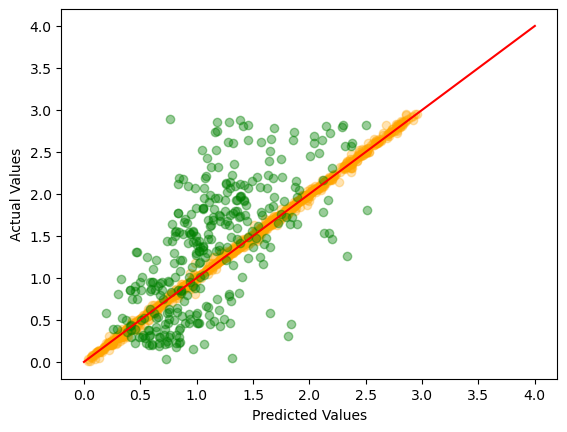

In [35]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [36]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveLGBM(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-24 13:09:05,595] A new study created in memory with name: lgbm_parameter_opt
[I 2023-08-24 13:09:09,102] Trial 0 finished with value: 0.618037877517778 and parameters: {'n_estimators': 831, 'max_depth': 15, 'num_leaves': 27, 'min_child_samples': 9, 'num_iterations': 851}. Best is trial 0 with value: 0.618037877517778.
[I 2023-08-24 13:09:09,383] Trial 1 finished with value: 0.5227082252294639 and parameters: {'n_estimators': 911, 'max_depth': 1, 'num_leaves': 26, 'min_child_samples': 1, 'num_iterations': 535}. Best is trial 0 with value: 0.618037877517778.
[I 2023-08-24 13:09:12,238] Trial 2 finished with value: 0.6327303645189639 and parameters: {'n_estimators': 867, 'max_depth': 23, 'num_leaves': 18, 'min_child_samples': 1, 'num_iterations': 824}. Best is trial 2 with value: 0.6327303645189639.
[I 2023-08-24 13:09:13,524] Trial 3 finished with value: 0.6079241072747298 and parameters: {'n_estimators': 849, 'max_depth': 18, 'num_leaves': 7, 'min_child_samples': 3, 'num_iter

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 13:09:44,889] Trial 17 finished with value: 0.6407612689024988 and parameters: {'n_estimators': 549, 'max_depth': 19, 'num_leaves': 31, 'min_child_samples': 1, 'num_iterations': 900}. Best is trial 17 with value: 0.6407612689024988.
[I 2023-08-24 13:09:49,437] Trial 18 finished with value: 0.6394817867452064 and parameters: {'n_estimators': 504, 'max_depth': 11, 'num_leaves': 32, 'min_child_samples': 1, 'num_iterations': 975}. Best is trial 17 with value: 0.6407612689024988.
[I 2023-08-24 13:09:53,771] Trial 19 finished with value: 0.6316476682383833 and parameters: {'n_estimators': 505, 'max_depth': 11, 'num_leaves': 32, 'min_child_samples': 3, 'num_iterations': 995}. Best is trial 17 with value: 0.6407612689024988.
[I 2023-08-24 13:09:58,348] Trial 20 finished with value: 0.6324646379588973 and parameters: {'n_estimators': 578, 'max_depth': 9, 'num_leaves': 32, 'min_child_samples': 2, 'num_iterations': 996}. Best is trial 17 with value: 0.6407612689024988.
[I 2023-08-24

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 13:10:55,642] Trial 36 finished with value: 0.6383740488191338 and parameters: {'n_estimators': 585, 'max_depth': 17, 'num_leaves': 31, 'min_child_samples': 1, 'num_iterations': 947}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-24 13:10:57,758] Trial 37 finished with value: 0.634957521468977 and parameters: {'n_estimators': 540, 'max_depth': 18, 'num_leaves': 26, 'min_child_samples': 3, 'num_iterations': 577}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-24 13:11:00,647] Trial 38 finished with value: 0.6303803872804281 and parameters: {'n_estimators': 809, 'max_depth': 26, 'num_leaves': 22, 'min_child_samples': 1, 'num_iterations': 830}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-24 13:11:03,633] Trial 39 finished with value: 0.6206028697602208 and parameters: {'n_estimators': 701, 'max_depth': 13, 'num_leaves': 28, 'min_child_samples': 8, 'num_iterations': 781}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-24

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 13:11:26,944] Trial 46 finished with value: 0.6400750595321405 and parameters: {'n_estimators': 553, 'max_depth': 19, 'num_leaves': 31, 'min_child_samples': 3, 'num_iterations': 868}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-24 13:11:29,727] Trial 47 finished with value: 0.6313647702892348 and parameters: {'n_estimators': 884, 'max_depth': 13, 'num_leaves': 27, 'min_child_samples': 2, 'num_iterations': 715}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-24 13:11:32,227] Trial 48 finished with value: 0.6251160723179422 and parameters: {'n_estimators': 517, 'max_depth': 25, 'num_leaves': 20, 'min_child_samples': 1, 'num_iterations': 790}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-24 13:11:34,443] Trial 49 finished with value: 0.6137253498157741 and parameters: {'n_estimators': 661, 'max_depth': 6, 'num_leaves': 20, 'min_child_samples': 7, 'num_iterations': 917}. Best is trial 22 with value: 0.6510108902824966.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 13:11:37,879] Trial 50 finished with value: 0.6153823061020589 and parameters: {'n_estimators': 588, 'max_depth': 14, 'num_leaves': 31, 'min_child_samples': 10, 'num_iterations': 826}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-24 13:11:41,209] Trial 51 finished with value: 0.6377555922547431 and parameters: {'n_estimators': 529, 'max_depth': 15, 'num_leaves': 25, 'min_child_samples': 1, 'num_iterations': 863}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-24 13:11:44,833] Trial 52 finished with value: 0.6457433682934454 and parameters: {'n_estimators': 953, 'max_depth': 13, 'num_leaves': 27, 'min_child_samples': 1, 'num_iterations': 873}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-24 13:11:48,671] Trial 53 finished with value: 0.6381946210028115 and parameters: {'n_estimators': 960, 'max_depth': 12, 'num_leaves': 28, 'min_child_samples': 1, 'num_iterations': 898}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 13:12:46,331] Trial 71 finished with value: 0.6434827954112592 and parameters: {'n_estimators': 620, 'max_depth': 20, 'num_leaves': 31, 'min_child_samples': 1, 'num_iterations': 952}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-24 13:12:50,659] Trial 72 finished with value: 0.6374535953032007 and parameters: {'n_estimators': 701, 'max_depth': 21, 'num_leaves': 30, 'min_child_samples': 1, 'num_iterations': 955}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-24 13:12:54,198] Trial 73 finished with value: 0.6376363408910299 and parameters: {'n_estimators': 611, 'max_depth': 14, 'num_leaves': 26, 'min_child_samples': 2, 'num_iterations': 944}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-24 13:12:58,267] Trial 74 finished with value: 0.6449302710874952 and parameters: {'n_estimators': 677, 'max_depth': 17, 'num_leaves': 29, 'min_child_samples': 1, 'num_iterations': 918}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-2

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 13:13:34,177] Trial 83 finished with value: 0.6372740130903247 and parameters: {'n_estimators': 654, 'max_depth': 15, 'num_leaves': 31, 'min_child_samples': 2, 'num_iterations': 879}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-24 13:13:37,879] Trial 84 finished with value: 0.6413712793977643 and parameters: {'n_estimators': 642, 'max_depth': 16, 'num_leaves': 27, 'min_child_samples': 1, 'num_iterations': 891}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-24 13:13:41,958] Trial 85 finished with value: 0.6453906643244298 and parameters: {'n_estimators': 709, 'max_depth': 19, 'num_leaves': 29, 'min_child_samples': 1, 'num_iterations': 913}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-24 13:13:45,609] Trial 86 finished with value: 0.6298471051086414 and parameters: {'n_estimators': 711, 'max_depth': 19, 'num_leaves': 28, 'min_child_samples': 2, 'num_iterations': 902}. Best is trial 22 with value: 0.6510108902824966.
[I 2023-08-2

Best r2:  0.6510108902824966
Best trial: {'n_estimators': 547, 'max_depth': 15, 'num_leaves': 29, 'min_child_samples': 1, 'num_iterations': 925}


In [37]:
optuna.visualization.plot_parallel_coordinate(study)

In [38]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 547, 'max_depth': 15, 'num_leaves': 29, 'min_child_samples': 1, 'num_iterations': 925}


547

In [39]:
lgbm_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "num_leaves": study.best_trial.params["num_leaves"],
    "min_child_samples": study.best_trial.params["min_child_samples"],
    "num_iterations": study.best_trial.params["num_iterations"]
}

lgbm = LGBMRegressor(**lgbm_params)
lgbm.fit(Cd_X_train, Cd_y_train)

LGBMRegressor(max_depth=15, min_child_samples=1, n_estimators=547,
              num_iterations=925, num_leaves=29, random_state=42)

In [40]:
y_train_pred = lgbm.predict(Cd_X_train)
y_test_pred = lgbm.predict(Cd_X_test)

In [41]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.010716863142254845
Test RMSE:  0.19502573853833866


In [42]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.9980424968829523
Test R2:  0.3374380136117725


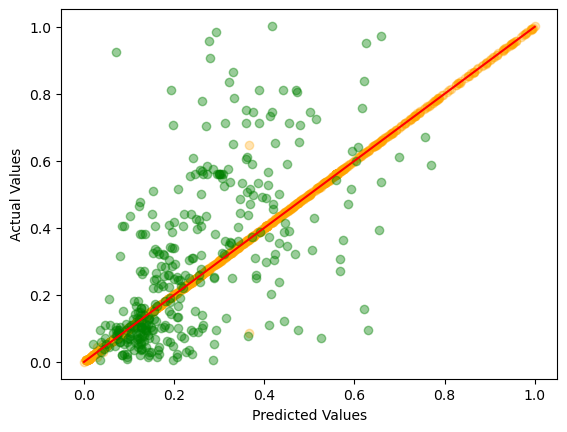

In [43]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 1.0], [0, 1.0], color='red', linestyle='-')

plt.show()

Ni

In [44]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveLGBM(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-24 13:14:27,717] A new study created in memory with name: lgbm_parameter_opt
[I 2023-08-24 13:14:29,674] Trial 0 finished with value: 0.73207974329966 and parameters: {'n_estimators': 610, 'max_depth': 5, 'num_leaves': 26, 'min_child_samples': 7, 'num_iterations': 769}. Best is trial 0 with value: 0.73207974329966.
[I 2023-08-24 13:14:32,460] Trial 1 finished with value: 0.7322441274959284 and parameters: {'n_estimators': 971, 'max_depth': 8, 'num_leaves': 28, 'min_child_samples': 5, 'num_iterations': 682}. Best is trial 1 with value: 0.7322441274959284.
[I 2023-08-24 13:14:34,780] Trial 2 finished with value: 0.742850445494631 and parameters: {'n_estimators': 697, 'max_depth': 16, 'num_leaves': 22, 'min_child_samples': 5, 'num_iterations': 687}. Best is trial 2 with value: 0.742850445494631.
[I 2023-08-24 13:14:38,368] Trial 3 finished with value: 0.7405979169241672 and parameters: {'n_estimators': 516, 'max_depth': 12, 'num_leaves': 32, 'min_child_samples': 4, 'num_iterati

Best r2:  0.7576324104930741
Best trial: {'n_estimators': 576, 'max_depth': 15, 'num_leaves': 11, 'min_child_samples': 9, 'num_iterations': 936}


In [45]:
optuna.visualization.plot_parallel_coordinate(study)

In [46]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 576, 'max_depth': 15, 'num_leaves': 11, 'min_child_samples': 9, 'num_iterations': 936}


576

In [47]:
lgbm_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "num_leaves": study.best_trial.params["num_leaves"],
    "min_child_samples": study.best_trial.params["min_child_samples"],
    "num_iterations": study.best_trial.params["num_iterations"]
}

lgbm = LGBMRegressor(**lgbm_params)
lgbm.fit(Ni_X_train, Ni_y_train)

LGBMRegressor(max_depth=15, min_child_samples=9, n_estimators=576,
              num_iterations=936, num_leaves=11, random_state=42)

In [48]:
y_train_pred = lgbm.predict(Ni_X_train)
y_test_pred = lgbm.predict(Ni_X_test)

In [49]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.09618135043915307
Test RMSE:  0.91832214319927


In [50]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.993708312108709
Test R2:  0.4377498779216762


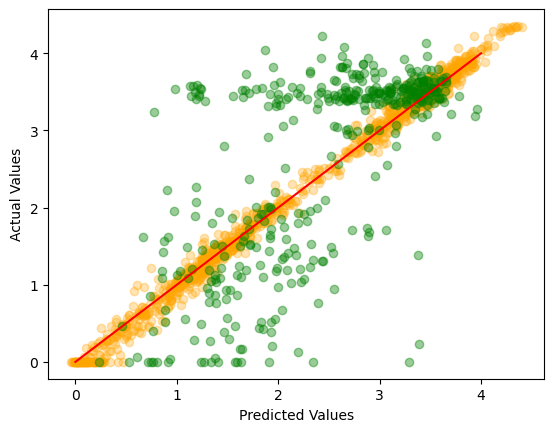

In [51]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()